<h1>Convolutions</h1>
<img src="https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="750" align="center">
The 2D Image convolution is a fairly simple operation that leads to powerful and somewhat surprising results! In this notebook we'll look at performing convolutions with a hand-crafted kernal and then look at how learn the parameters of a kernal to perform some task.

Have a look at this interactive convolution visualiser
[Convolution Visualizer](https://ezyang.github.io/convolution-visualizer/index.html)

In [1]:
import math
import random
import numpy as np
from PIL import Image
import copy

from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


Load a test image to experiment with using the Python Imaging Library (PIL).<br>
Note: PIL images are themselves objects and the image can be displayed just by printing them

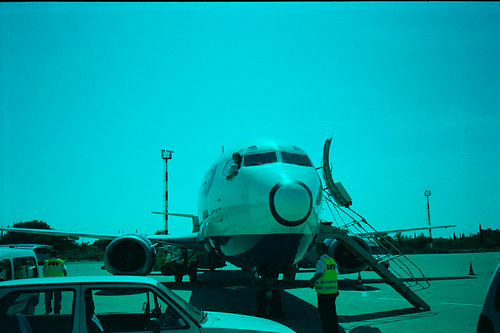

In [3]:
test_img1 = Image.open("Plane.png").convert('RGB')
test_img1

In [4]:
# Create a Pytorch "transform" using the torchvision library
# This particular transform simply takes a PIL image and converts it to a tensor
transform = T.ToTensor()
test_img1 = transform(test_img1)
print("Image Shape: ", test_img1.shape)
#NOTE:Many torchvision functions with only work on PIL images

Image Shape:  torch.Size([3, 333, 500])


<h2>Hand Crafted Convolution Kernels</h2>

<h3>Sobel Edge Detector</h3>
The <a href="https://en.wikipedia.org/wiki/Sobel_operator">Sobel Edge detector</a> is a famous and simple convolutional kernal filter that will "extract" the edges of an image and was/is extensively used as a part of many algorithms. Here a Sobel Filter will be created and use it on the test image.<br><br>
Convolution with a Sobel Kernel (left) and the features extracted by a Sobel edge detector (right)<br>
<img src="https://miro.medium.com/max/1356/1*-OM6jQTMNACDX2vAh_lvMQ.png" width="480" align="left">
<img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Bikesgraysobel.jpg" width="480" align="right">



In [5]:
# First must create a filter that will extract edges in the X direction
gx = torch.FloatTensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]).unsqueeze(0)
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gx.shape)
print(gx)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [6]:
#Now must create a filter that will extract edges in the Y direction
gy = torch.FloatTensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).unsqueeze(0)
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gy.shape)
print(gy)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


<h3>Convolutions in Pytorch </h3>

For the function Conv2d (which performs the convolution operation) the convolutional kernel must be of the shape  <br>
<b>[out channels, in channels, kernel height, kernel width]</b> <br>
The input image must have the shape <br>
<b>[minibatch size, in channels, image height, image width]</b> <br>

Feature Map Shape:  torch.Size([1, 1, 331, 498])


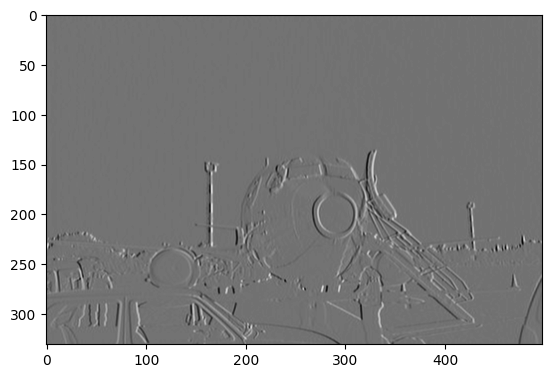

In [7]:
#convolve the image with the X direction kernel
conv_out1 = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, stride=1)
print("Feature Map Shape: ", conv_out1.shape)

_ = plt.imshow(torch.squeeze(conv_out1), cmap='gray')

Feature Map Shape:  torch.Size([1, 1, 331, 498])


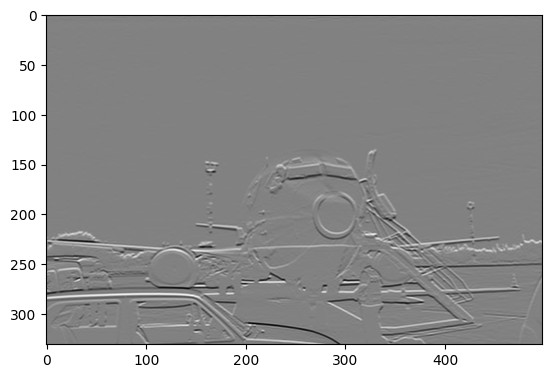

In [8]:
#convolve the image with the Y direction kernel
conv_out2 = F.conv2d(test_img1.unsqueeze(0), gy, bias=None, stride=1)
print("Feature Map Shape: ", conv_out2.shape)

_ = plt.imshow(torch.squeeze(conv_out2), cmap='gray')

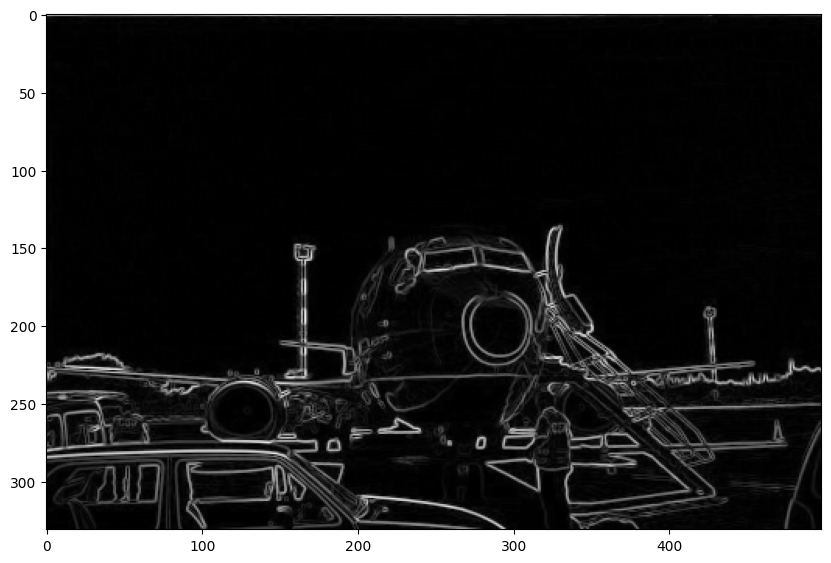

In [9]:
#Combine the two resulting images together by finding the magnitude
conv_out = (conv_out1.pow(2) + conv_out2.pow(2)).sqrt()
plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out.squeeze(), cmap='gray')

<h3>Convolutional layers </h3>
Instead of doing each convolution separately, concatenating the kernels and performing the convolution with both kernels are in one step. The ouput will have the 2D feature maps from each kernel concatenated along the channel dimension!

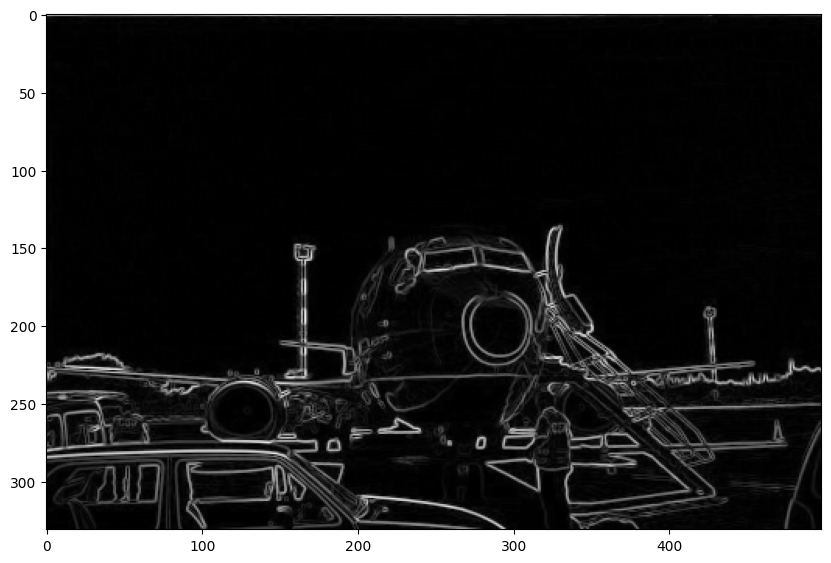

In [10]:
# Concatenate both kernels
g_xy = torch.cat((gx, gy), 0)

# Perform the convolutions of both kernels in the same step
conv_out3 = F.conv2d(test_img1.unsqueeze(0), g_xy, bias=None, stride=1)

# now easily find the magnitude
conv_out_mag = conv_out3.pow(2).sum(1).sqrt()

plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out_mag.squeeze(), cmap='gray')